In [65]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

import numpy as np
import os

from IPython.display import display
from scipy.stats import chi2, norm

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.makers.utils import make_theta_squared_table
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True
from gammapy.visualization import plot_spectrum_datasets_off_regions, plot_theta_squared_table

from regions import CircleSkyRegion


In [23]:
data_store = DataStore.from_dir(
    f"$GAMMAPY_DATA/hess-dl3-dr1"
)

In [11]:
display(data_store.obs_table)

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


In [9]:
src = dict()
src['Name'] = 'PKS 2155-304'
src['Position'] = SkyCoord.from_name(src['Name'])
src['Redshift'] = 0.116

In [12]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=src['Position'].ra,
    lat=src['Position'].dec,
    radius="3 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)

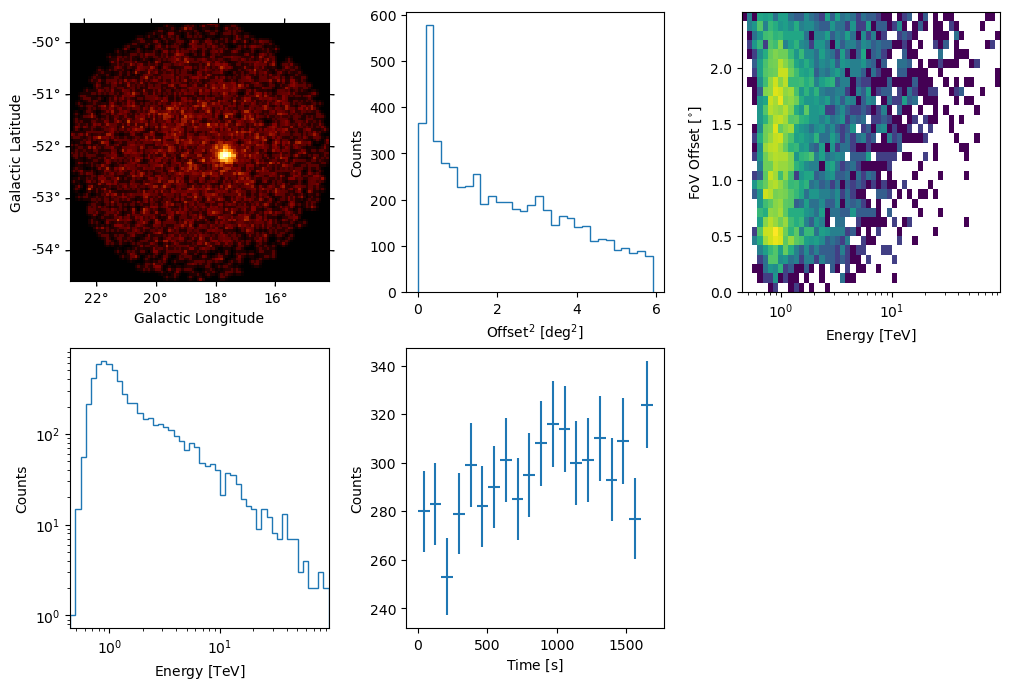

In [15]:
obs = data_store.obs(obs_ids[0])
obs.events.select_offset([0, 2.5] * u.deg).peek()

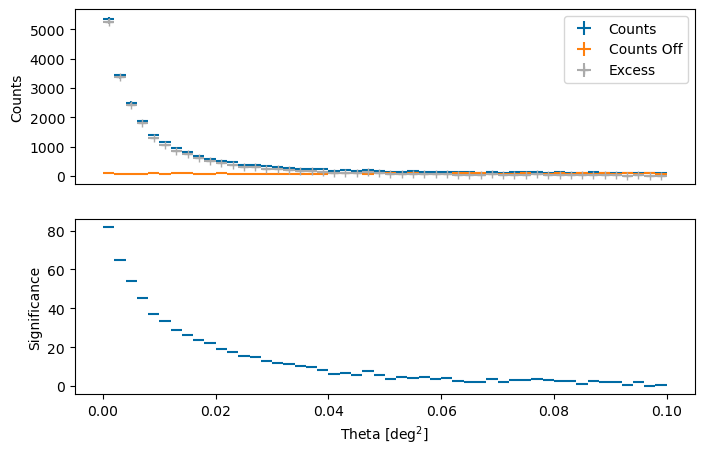

In [21]:
theta2_axis = MapAxis.from_bounds(0, 0.1, nbin=50, interp="lin", unit="deg2")

theta2_table = make_theta_squared_table(
    observations=observations,
    position=src['Position'],
    theta_squared_axis=theta2_axis,
)

plt.figure(figsize=(8, 5))
plot_theta_squared_table(theta2_table)
plt.show()

In [26]:
on_region_radius = Angle("0.1 deg")
on_region = CircleSkyRegion(center=src['Position'], radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=src['Position'],radius=0.5 * u.deg)
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=src['Position'], proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

# Data reduction

In [33]:
energy_axis = MapAxis.from_energy_bounds(0.02, 200, nbin=20, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 300, nbin=30, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["bkg-peak", "aeff-max"], aeff_percent=10)

In [34]:
%%time

# Parallel version
makers = [dataset_maker, bkg_maker, safe_mask_maker]  # the order matters
datasets_maker = DatasetsMaker(makers, stack_datasets=False, n_jobs=8)
datasets = datasets_maker.run(dataset_empty, observations)

Data reduction:   0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 1.54 s, sys: 121 ms, total: 1.66 s
Wall time: 4.61 s


In [38]:
%%time

# Non-parallel version

datasets = Datasets()

for obs in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs
    )
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

CPU times: user 14.4 s, sys: 75 ms, total: 14.5 s
Wall time: 14.5 s


/cvmfs/sw.hess-experiment.eu/software/conda/envs/gammapy-1.2/lib/python3.10/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


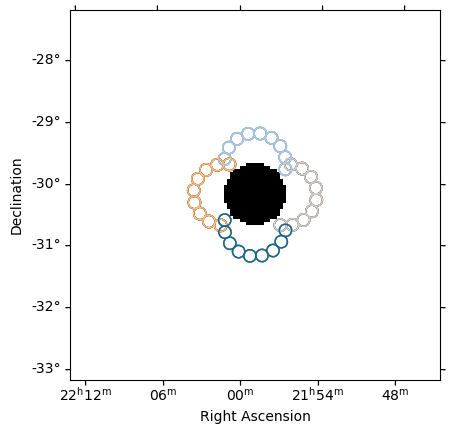

In [41]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [43]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,177,164.44444274902344,21.24011050904081,12.555556297302246,29.000000206530096,29.000000206530096,nan,2307815.0,956501696.0,1645.9436731394428,1689.000000000005,0.10753709430553808,0.007628181025997085,0.09990891270013215,80,48,wstat,481.56336709031734,113,48.0,431.9999694824219,0.111111119389534
stacked,805,781.7777709960938,52.14816944943998,23.22222328186035,101.40000219471752,101.40000219471752,nan,2723258.0,1531970048.0,3242.0454647149895,3378.0000000000005,0.24830003427196481,0.007162830853114466,0.24113720165390104,80,51,wstat,2793.218304471906,209,51.0,458.9999694824219,0.111111119389534
stacked,2038,2003.0,87.17254091474663,35.0,235.30000362366437,235.30000362366437,nan,431920.1875,2049040000.0,4825.489054074511,5065.999999999999,0.42234061193842487,0.007253150842907199,0.4150874610955177,80,53,wstat,7730.951306391487,315,53.0,477.0,0.1111111119389534
stacked,3613,3559.666748046875,117.39139074936415,53.333335876464844,409.30000928647814,409.30000928647814,nan,1844916.25,2468012800.0,6386.866192122923,6756.000000000001,0.5656921393556046,0.008350470210608474,0.5573416822849833,80,56,wstat,13934.537541285988,480,56.0,503.9999694824219,0.111111119389534
stacked,5002,4933.77783203125,138.88171654429308,68.22222900390625,561.6000083041191,561.6000083041191,nan,333416.5,2825196032.0,7954.743777347735,8445.000000000005,0.628807179716323,0.008576294964795568,0.6202308924243273,80,57,wstat,19458.16321810762,614,57.0,512.9999389648438,0.111111119389534
stacked,6385,6296.888671875,156.78729256007213,88.11111450195312,717.8000137148051,717.8000137148051,nan,2486206.5,3139006208.0,9517.102900041273,10133.000000000004,0.6708974429573846,0.009258186596004022,0.6616392339151542,80,58,wstat,24780.022192979533,793,58.0,522.0,0.1111111119389534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,12456,12209.4443359375,212.9827870805781,246.55555725097656,1467.5000503772494,1467.5000503772494,nan,30290800.0,7345357312.0,25258.837867734957,27021.0,0.4931343264969051,0.009761159976640128,0.4833731622915857,80,60,wstat,45738.9869297433,2219,60.0,540.0,0.1111111119389534


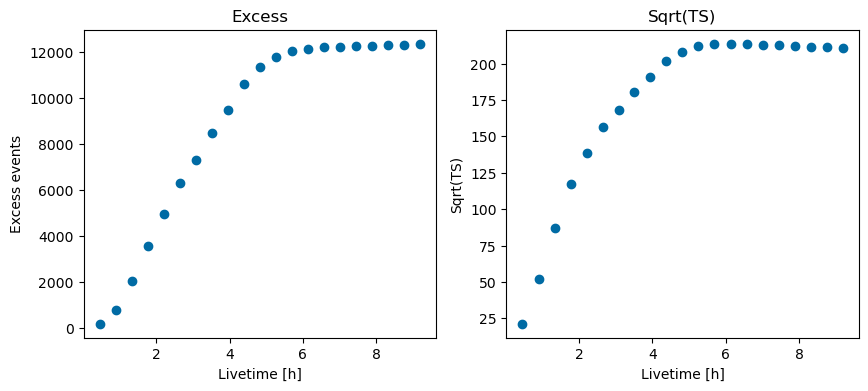

In [44]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

plt.show()

In [45]:
dataset_stack = datasets.stack_reduce(name="hess")

# Fit stacked spectrum

In [50]:
ebl_model = 'dominguez'

if 'GAMMAPY_DATA' not in os.environ:
    os.environ['GAMMAPY_DATA'] = '/sps/hess/prod/gammapy/datasets/1.2'

absorption = EBLAbsorptionNormSpectralModel.read_builtin(ebl_model, redshift=src['Redshift'])

In [53]:
dataset_pl = Datasets([dataset_stack])

spectral_model_pl = PowerLawSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                          reference=300. * u.Unit("GeV"),
                                          index=2.
                                         )  * absorption
spectral_model_pl.parameters["amplitude"].frozen = False
spectral_model_pl.parameters["amplitude"].min = 0.
spectral_model_pl.parameters["index"].frozen = False
spectral_model_pl.parameters["redshift"].frozen = True

source_pl = SkyModel(
    spectral_model=spectral_model_pl,
    name=src['Name'],
)

dataset_pl["hess"].models = source_pl
print(dataset_pl)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : hess
  Instrument : 
  Models     : ['PKS 2155-304']




In [57]:
%%time

fit_pl = Fit()
result_pl = fit_pl.run(datasets=dataset_pl)

# we make a copy here to compare it later
model_best_pl = source_pl.copy(name=src['Name'])

CPU times: user 1.19 s, sys: 151 ms, total: 1.34 s
Wall time: 10.1 s


In [58]:
dataset_lp = Datasets([dataset_stack])

spectral_model_lp = LogParabolaSpectralModel(amplitude=1e-7 * u.Unit("cm-2 s-1 TeV-1"),
                                             reference=300. * u.Unit("GeV"),
                                             alpha=2.,
                                             beta=0.01,
                                            )  * absorption
spectral_model_lp.parameters["amplitude"].frozen = False
spectral_model_lp.parameters["amplitude"].min = 0.
spectral_model_lp.parameters["alpha"].frozen = False
spectral_model_lp.parameters["beta"].frozen = False
spectral_model_lp.parameters["redshift"].frozen = True
spectral_model_lp.parameters["beta"].min = 0.

source_lp = SkyModel(
    spectral_model=spectral_model_lp,
    name=src['Name'],
)

dataset_lp["hess"].models = source_lp
print(dataset_lp)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : hess
  Instrument : 
  Models     : ['PKS 2155-304']




In [60]:
%%time

fit_lp = Fit()
result_lp = fit_lp.run(datasets=dataset_lp)

# we make a copy here to compare it later
model_best_lp = source_lp.copy(name=src['Name'])

CPU times: user 256 ms, sys: 4.08 ms, total: 260 ms
Wall time: 256 ms


In [63]:
def sigma_lp_vs_pl():
    ts_pl = result_pl.total_stat
    ts_lp = result_lp.total_stat
    Delta_TS = ts_pl-ts_lp
    p_value = chi2.sf(Delta_TS, df=1)
    sigma = norm.isf(0.5*p_value)
    return sigma

In [64]:
sigma_lp_pl = sigma_lp_vs_pl()
if sigma_lp_pl >= 3.0:
    print(f"Log-parabola preferred over a power-law at {sigma_lp_pl:.2f} sigmas.")
    result = result_lp
    fit = fit_lp
    dataset = Datasets(dataset_lp)
    model_best = model_best_lp.copy(name=src['Name'])
else:
    print(f"Log-parabola *not* preferred over a power-law (Delta TS(log-parabola vs power-law)={sigma_lp_pl:.2f} sigmas).")
    result = result_pl
    fit = fit_pl
    dataset = Datasets(dataset_pl)
    model_best = model_best_pl.copy(name=src['Name'])
    
source = SkyModel(
    spectral_model=model_best.spectral_model,
    name=src['Name'],
)
dataset["hess"].models = source

NameError: name 'chi2' is not defined